In [1]:
"""\
# Copyright (C) 2024 Jesús Bautista Villar <jesbauti20@gmail.com>
"""
!python --version

Python 3.10.12


In [301]:
import os
import numpy as np
from numpy import linalg as LA

# Plotting
import matplotlib.pyplot as plt
from seaborn import color_palette

# Animations
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.patches as patches

# Formations control simulation frames
from sf_complex import sim_frame_complex
from sf_affine import sim_frame_affine
from sf_affine_complex import sim_frame_affine_complex

# Happy pdf for a happy submission without 
# complains in paperplaza, arxiv, etc
import matplotlib

font = {'size' : 16}
matplotlib.rc('font', **font)

## Diagonalization of A

In [41]:
a = 2
omega = 1
hx = 0
hy = 0

A = a*np.eye(2) + omega*np.array([[0,-1],[1,0]]) + np.array([[0,hx],[hy,0]])
print("A =\n",A,"\n")

# Predicted eigen values and eigenvectors
lambda1 = a + np.sqrt((hx - omega)*(hy + omega) + 0j)
lambda2 = a - np.sqrt((hx - omega)*(hy + omega) + 0j)

if hx-omega == 0 and hy+omega == 0: # The matrix is already diagonal
    v1 = np.array([1, 0])
    v2 = np.array([0, 1])
elif hx-omega != 0 and hy+omega !=0: # Diagonalizable
    a = np.sqrt(hx - omega + 0j)
    b = np.sqrt(hy + omega + 0j)
    denom = np.sqrt(a*np.conj(a) + b*np.conj(b))

    v1 = np.array([a,  b])/denom
    v2 = np.array([a, -b])/denom
elif hx-omega != 0: # Not diagonalizable (we need 2 generalized eigenvectors)
    v1 = np.array([1, 0])
    v2 = np.array([0, 1/(hx-omega)])
else: # (hy+omega != 0) Not diagonalizable (we need 2 generalized eigenvectors)
    v1 = np.array([0, 1])
    v2 = np.array([1/(hy+omega), 0])

V = np.array([v1,v2]).T

print("------- Predicted")
with np.printoptions(precision=3, suppress=True):
    print("lambda_1 = {:.3f} -- ".format(lambda1), v1)
    print("lambda_2 = {:.3f} -- ".format(lambda2), v2)
    #print("Diagonalization check (A - VDV^-1):\n", A - V@np.array([[lambda1,0],[0,lambda2]])@LA.inv(V))
# print((A - lambda1*np.eye(2))@v1[:,None])
# print((A - lambda2*np.eye(2))@v2[:,None])

# Comparing with the computed eigen values and eigenvectors
print("------- Computed")
lambdas, vs = LA.eig(A)
with np.printoptions(precision=3, suppress=True):
    print("lambdas: ", lambdas)
    print("v1 = ", vs[:,0])
    print("v2 = ", vs[:,1])

A =
 [[ 2. -1.]
 [ 1.  2.]] 

------- Predicted
lambda_1 = 2.000+1.000j --  [0.   +0.707j 0.707+0.j   ]
lambda_2 = 2.000-1.000j --  [ 0.   +0.707j -0.707+0.j   ]
------- Computed
lambdas:  [2.+1.j 2.-1.j]
v1 =  [0.707+0.j    0.   -0.707j]
v2 =  [0.707-0.j    0.   +0.707j]


### Differential equation 
$$\dot x(t) = A x(t) \quad \Longrightarrow \quad x(t) = e^{At}x(0)$$

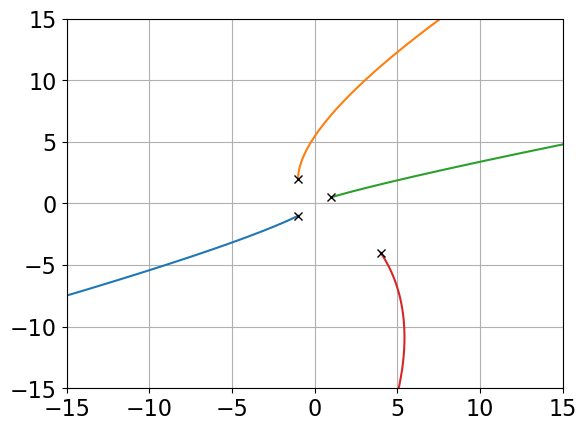

In [10]:
## Analytical solution
tf = 2
t = np.linspace(0,tf,1000)[:,None]
v1 = v1.reshape(2,1)
v2 = v2.reshape(2,1)

fig, ax = plt.subplots()

if hx-omega == 0 and hy+omega == 0:
    c_list = ((2,1),(-1,0),(2,2),(-2,2))
    for c_pair in c_list:
        c1 = c_pair[0]
        c2 = c_pair[1]
        
        x = x = np.exp(a*t)*(c1*v1.T + c2*v2.T)

        ax.plot(x[:,0], x[:,1])
        ax.plot(x[0,0], x[0,1], "xk")
        
elif hx-omega != 0 and hy+omega !=0:
    c_list = ((10,1),(-1,0),(2,2),(-2,2))
    for c_pair in c_list:
        c1 = c_pair[0]
        c2 = c_pair[1]

        x =  c1*np.squeeze(np.exp(lambda1.real*t))*(np.real(v1)*np.cos(lambda1.imag*t).T + \
                                                    np.imag(v1)*np.sin(lambda1.imag*t).T)  \
            +c2*np.squeeze(np.exp(lambda2.real*t))*(np.real(v2)*np.cos(lambda2.imag*t).T + \
                                                    np.imag(v2)*np.sin(lambda2.imag*t).T)
        x = x.T

        ax.plot(x[:,0], x[:,1])
        ax.plot(x[0,0], x[0,1], "xk")

elif hx-omega != 0:
    c_list = ((-1,-1),(-1,2),(1,0.5),(4,-4))
    for c_pair in c_list:
        c1 = c_pair[0]
        c2 = c_pair[1]

        x =  c1*np.exp(a*t)*v1.T + c2*np.exp(a*t)*(v2.T + t*v1.T)

        ax.plot(x[:,0], x[:,1])
        ax.plot(x[0,0], x[0,1], "xk")

k = 3
ax.set_xlim([-k*5,k*5])
ax.set_ylim([-k*5,k*5])
ax.grid(True)
plt.show()

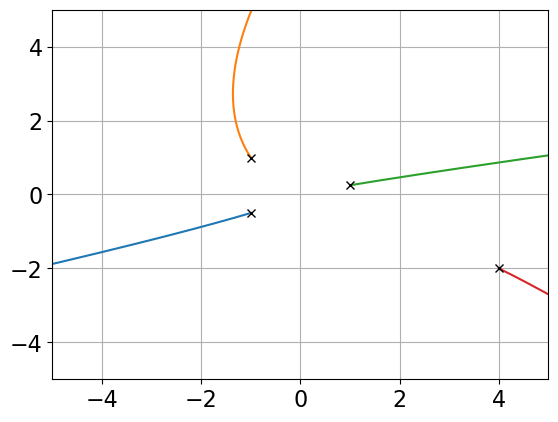

In [11]:
## Euler integration
tf = 2
dt = tf/1000
its = int(tf/dt)

fig, ax = plt.subplots()

if hx-omega == 0 and hy+omega == 0:
    x0_list = [[2,1.1], [-1,0], [2,2], [-2,2]]
elif hx-omega != 0 and hy+omega !=0:
    x0_list = [[1.5,-1], [-1.5,-1], [2,1], [-3,1]]
elif hx-omega != 0:
    x0_list = [[-1,-0.5], [-1,1], [1,0.25], [4,-2]]

for x0 in x0_list:
    x_data = []
    x = np.array(x0)[:,None]
    for it in range(its):
        x_data.append(x)
        x = x + A@x*dt
    x_data = np.squeeze(np.array(x_data)).T
    ax.plot(x_data[0,:], x_data[1,:])
    ax.plot(x_data[0,0], x_data[1,0], "kx")

ax.set_xlim([-5,5])
ax.set_ylim([-5,5])
ax.grid(True)
plt.show()

## Diagonalization of $(I_n \otimes A)$

In [55]:
LA.eig(np.eye(4))

(array([1., 1., 1., 1.]),
 array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]))

In [125]:
a = 0
omega = 1/np.sqrt(2)
hx = 0
hy = 0

A = a*np.eye(2) + omega*np.array([[0,-1],[1,0]]) + np.array([[0,hx],[hy,0]])

n = 4
A_bar = np.kron(np.eye(n),A)

# Predicted eigen values and eigenvectors
lambda1 = a + np.sqrt((hx - omega)*(hy + omega) + 0j)
lambda2 = a - np.sqrt((hx - omega)*(hy + omega) + 0j)

if hx-omega == 0 and hy+omega == 0: # The matrix is already diagonal
    v1 = np.array([1, 0])
    v2 = np.array([0, 1])
elif hx-omega != 0 and hy+omega !=0: # Diagonalizable
    a = np.sqrt(hx - omega + 0j)
    b = np.sqrt(hy + omega + 0j)
    denom = np.sqrt(a*np.conj(a) + b*np.conj(b))

    v1 = np.array([a,  b])/denom
    v2 = np.array([a, -b])/denom
elif hx-omega != 0: # Not diagonalizable (we need 2 generalized eigenvectors)
    v1 = np.array([1, 0])
    v2 = np.array([0, 1/(hx-omega)])
else: # (hy+omega != 0) Not diagonalizable (we need 2 generalized eigenvectors)
    v1 = np.array([0, 1])
    v2 = np.array([1/(hy+omega), 0])

print(A_bar)
print("------- Predicted")
with np.printoptions(precision=3, suppress=True):
    print("u_1 = {:.3f} -- ".format(lambda1), v1)
    print("u_2 = {:.3f} -- ".format(lambda2), v2)

# Comparing with the computed eigen values and eigenvectors
print("------- Computed")
lambdas_c, V_c = LA.eig(A_bar)
with np.printoptions(precision=3, suppress=True):
    print("lambdas: ", lambdas_c)
    print("V = \n", V_c)

[[ 0.         -0.70710678  0.         -0.          0.         -0.
   0.         -0.        ]
 [ 0.70710678  0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.         -0.          0.         -0.70710678  0.         -0.
   0.         -0.        ]
 [ 0.          0.          0.70710678  0.          0.          0.
   0.          0.        ]
 [ 0.         -0.          0.         -0.          0.         -0.70710678
   0.         -0.        ]
 [ 0.          0.          0.          0.          0.70710678  0.
   0.          0.        ]
 [ 0.         -0.          0.         -0.          0.         -0.
   0.         -0.70710678]
 [ 0.          0.          0.          0.          0.          0.
   0.70710678  0.        ]]
------- Predicted
u_1 = 0.000+0.707j --  [0.   +0.707j 0.707+0.j   ]
u_2 = 0.000-0.707j --  [ 0.   +0.707j -0.707+0.j   ]
------- Computed
lambdas:  [0.+0.707j 0.-0.707j 0.+0.707j 0.-0.707j 0.+0.707j 0.-0.707j 0.+0.707j
 0.-0.707j]
V = 
 [[0.707+0

In [18]:
(A_bar - np.eye(2*n)*lambda1) @ V_c[:,0:1]

array([[0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j]])

## Diagonalization of $\tilde L$

### Square

In [310]:
## Parameters #####
n = 4
#Z = ((1,2), (2,3), (3,4), (4,1))
Z = ((1,2), (1,3), (2,3), (2,4), (3,4), (4,1))
p_star = np.array([[-1,-1], [-1,1], [1,1], [1,-1]]) # square
p0 = [[-10,-3], [-5,-2], [10,4], [0,-5]]
tf = 1
h = 3
kappa = 0.1
K = np.eye(n)

## Generate the simulation frame #####
args = {"n":n, "Z":Z, "p_star":p_star, "p0":p0, "tf":tf, "h":h, "kappa":kappa, "K":K, "debug":True}
sim_fr = sim_frame_affine_complex(**args)

Failed to dualize the problem: 'float' object is not iterable
W (6, 6) = 
 [[ 0.25  0.    0.    0.    0.    0.  ]
 [ 0.   -0.25  0.    0.    0.    0.  ]
 [ 0.    0.    0.25  0.    0.    0.  ]
 [ 0.    0.    0.   -0.25  0.    0.  ]
 [ 0.    0.    0.    0.    0.25  0.  ]
 [ 0.    0.    0.    0.    0.    0.25]]
L (4, 4) = 
 [[ 0.25 -0.25  0.25 -0.25]
 [-0.25  0.25 -0.25  0.25]
 [ 0.25 -0.25  0.25 -0.25]
 [-0.25  0.25 -0.25  0.25]]
 --------- Eigenvalues
lambda_0 = -0.000000
lambda_1 = -1.000000
lambda_2 = 0.000000
lambda_3 = -0.000000


In [131]:
## Eigenvectors that generates Ker(L) #####
sim_fr.check_eigen_vectors()

L@1_n           =  [0. 0. 0. 0.]
L@p^*           =  [-0.+0.j -0.+0.j  0.+0.j  0.-0.j]
L@(Im(p^*) + i(Re(p^*)) =  [ 0.-0.j  0.-0.j  0.+0.j -0.+0.j]
 ------------ 


In [313]:
## Set a desired velocity vector stack (v_f^*) #####
vx = 0
vy = 0
a = 1
omega = 0
hx = +1
hy = +0.1

## Design the weights that gerenates such v_f^* #####
mu_matrix_x = np.array([[0,0,0,-1], [0,0,-1,0], [0,1,0,0], [1,0,0,0]])/2
mu_matrix_y = np.array([[0,-1,0,0], [1,0,0,0], [0,0,0,1], [0,0,-1,0]])/2

mu_matrix_a = np.array([[0,1,0,1], [1,0,1,0], [0,1,0,1], [1,0,1,0]])/2
#mu_matrix_a = np.array([[0,0,1,0], [0,0,0,1], [1,0,0,0], [0,1,0,0]])/2

mu_matrix_w = np.array([[0,1,0,-1], [-1,0,1,0], [0,-1,0,1], [1,0,-1,0]])/2
mu_matrix_hx = np.array([[0,0,0,1], [0,0,-1,0], [0,1,0,0], [-1,0,0,0]])/2
mu_matrix_hy = np.array([[0,1,0,0], [-1,0,0,0], [0,0,0,1], [0,0,-1,0]])/2

sim_fr.set_manual_mu(a*mu_matrix_a + omega*mu_matrix_w + hx*mu_matrix_hx + hy*mu_matrix_hy)

print("--- Eigenvectors")
eg = LA.eig(-h*sim_fr.L_mod)
with np.printoptions(precision=3, suppress=True):
    print(eg[1][:,:])

M (4, 6) B.T (6, 4) K_inv (4, 4)
mu_ij matrix:
 [[0.   0.55 0.   1.  ]
 [0.45 0.   0.   0.  ]
 [0.   1.   0.   0.55]
 [0.   0.   0.45 0.  ]]
M:
 [[0.   0.55 0.   1.  ]
 [0.45 0.   0.   0.  ]
 [0.   1.   0.   0.55]
 [0.   0.   0.45 0.  ]]
M@B^T@p_star_c [-2.-1.1j  0.+0.9j  2.+1.1j  0.-0.9j]
 --------- Eigenvalues L_mod
lambda_0 = -2.800000
lambda_1 = 0.131623
lambda_2 = -0.000000
lambda_3 = 0.068377
--- Eigenvectors
[[ 0.48  -0.627 -0.5    0.326]
 [-0.519  0.326 -0.5   -0.627]
 [ 0.48   0.627 -0.5   -0.326]
 [-0.519 -0.326 -0.5    0.627]]


In [314]:
# Complex conjugate eigen values
l1 = kappa*(a + np.sqrt((hx-omega)*(hy+omega) + 0j))
l2 = kappa*(a - np.sqrt((hx-omega)*(hy+omega) + 0j))

with np.printoptions(precision=3, suppress=True):
    print("----- M @ B.T")
    print(sim_fr.M@sim_fr.B.T)
    # print("----- ")
    # eg = LA.eig(sim_fr.M@sim_fr.B.T)
    # print(eg[0])
    # print(eg[1][:,:])

    # print("----- Eigen vector of +real eigenvalue")
    # alfa = -(-a - (hx + hy)/2)
    # beta = (-a + (hx + hy)/2)
    # x = np.array([alfa, beta, alfa, beta])
    # print(x/np.sqrt(2*x[0]**2 + 2*x[1]**2))

    ps_re = np.real(sim_fr.p_star_c)
    ps_im = np.imag(sim_fr.p_star_c)
    
    if ((hx-omega) < 0):
        print("\n----- Eigenvector of complex-conjugate eigenvalues | ((hx-omega) < 0)")
        # beta = (hx+hy)/2 - np.sqrt((hx-omega)*(hy+omega) + 0j)
        # alfa = -(-omega + (hx-hy)/2)
        # v1 = np.array([alfa,beta,-alfa,-beta])
        # v2 = np.conjugate(v1)

        v1 = ((hx-hy)/2 - omega)*(ps_im + ps_re)/2 + ((hx+hy)/2 - np.sqrt((hx-omega)*(hy+omega) + 0j))*(ps_im - ps_re)/2
        v2 = np.conjugate(v1)
        
        
        print("v1 = ", v1/np.sqrt(2*v1[0]*np.conjugate(v1[0]) + 2*v1[1]*np.conjugate(v1[1])))
        print("v2 = ", v2/np.sqrt(2*v2[0]*np.conjugate(v2[0]) + 2*v2[1]*np.conjugate(v2[1])))

        print("test-v1 | kappa*M@B.T:", (kappa*sim_fr.M@sim_fr.B.T - np.eye(4)*l1) @ v1)
        print("test-v2 | kappa*M@B.T:", (kappa*sim_fr.M@sim_fr.B.T - np.eye(4)*l2) @ v2)
        print("test-v1 | -h*L_mod:", (-h*sim_fr.L_mod - np.eye(4)*l1) @ v1)
        print("test-v2 | -h*L_mod:", (-h*sim_fr.L_mod - np.eye(4)*l2) @ v2)
        print("----")
        print("test-v1 | -h*L:", (-h*sim_fr.L) @ v1)
        print("test-v2 | -h*L:", (-h*sim_fr.L) @ v2)
    else:
        print("\n----- Eigenvector of complex-conjugate eigenvalues | ((hx-omega) > 0)")
        beta = (hx+hy)/2 - np.sqrt((hx-omega)*(hy+omega) + 0j)
        alfa = -(-omega + (hx-hy)/2)
        v1 = np.array([alfa,beta,-alfa,-beta])
        
        v1 = ((hx-hy)/2 - omega)*(ps_im + ps_re)/2 + ((hx+hy)/2 - np.sqrt((hx-omega)*(hy+omega) + 0j))*(ps_im - ps_re)/2
        
        print("v1 = ", v1/np.sqrt(2*v1[0]*np.conjugate(v1[0]) + 2*v1[1]*np.conjugate(v1[1])))

        print("test-v1 | kappa*M@B.T:", (kappa*sim_fr.M@sim_fr.B.T - np.eye(n)*l1) @ v1)
        print("test-v1 | -h*L_mod:", (-h*sim_fr.L_mod - np.eye(n)*l1) @ v1)
        print("----")
        print("test-v1 | -h*L:", (-h*sim_fr.L) @ v1)
    

----- M @ B.T
[[ 1.55 -0.55  0.   -1.  ]
 [-0.45  0.45  0.    0.  ]
 [ 0.   -1.    1.55 -0.55]
 [ 0.    0.   -0.45  0.45]]

----- Eigenvector of complex-conjugate eigenvalues | ((hx-omega) > 0)
v1 =  [-0.627+0.j  0.326+0.j  0.627+0.j -0.326+0.j]
test-v1 | kappa*M@B.T: [-0.+0.j  0.+0.j  0.+0.j  0.+0.j]
test-v1 | -h*L_mod: [ 0.+0.j  0.+0.j  0.+0.j -0.+0.j]
----
test-v1 | -h*L: [ 0.+0.j -0.+0.j  0.+0.j  0.+0.j]


In [7]:
# We have the explicit form of the eigen values and eigen vectors. Now,
# let's see if we can connect them with the Kernel of L (1_n, p^*, ...)

print(sim_fr.M@sim_fr.B.T@np.real(sim_fr.p_star_c))
print(sim_fr.M@sim_fr.B.T@np.imag(sim_fr.p_star_c))

[-0.3 -1.7  0.3  1.7]
[-2.2 -0.2  2.2  0.2]


In [8]:
l1 = kappa*(a + np.sqrt((hx-omega)*(hy+omega) + 0j))
l2 = kappa*(a - np.sqrt((hx-omega)*(hy+omega) + 0j))

with np.printoptions(precision=4, suppress=True):
    print(np.array([l1,l2]))
    print("------")
    print(hy*np.imag(sim_fr.p_star_c) + 1j*hx*np.real(sim_fr.p_star_c))

    print("------")
    v = np.real(-sim_fr.p_star_c*1j)
    print((hx + hy*1j) * v)
    print((hy + hx*1j) * v)

    print("------")
    vf = (a + 1j*omega)*sim_fr.p_star_c + hx*np.imag(sim_fr.p_star_c) + 1j*hy*np.real(sim_fr.p_star_c)
    
    print(vf)
    #print(sim_fr.M@sim_fr.B.T @ sim_fr.p_star_c)
    print((sim_fr.L_mod*h) @ -sim_fr.p_star_c)
    print((sim_fr.L_mod*h) @ (np.imag(sim_fr.p_star_c) + 1j*np.real(sim_fr.p_star_c)))

[1.+0.9165j 1.-0.9165j]
------
[-0.2-0.3j  0.2-0.3j  0.2+0.3j -0.2+0.3j]
------
[-0.3-0.2j  0.3+0.2j  0.3+0.2j -0.3-0.2j]
[-0.2-0.3j  0.2+0.3j  0.2+0.3j -0.2-0.3j]
------
[-0.3-2.2j -1.7-0.2j  0.3+2.2j  1.7+0.2j]
[-0.3-2.2j -1.7-0.2j  0.3+2.2j  1.7+0.2j]
[ 2.2+0.3j  0.2+1.7j -2.2-0.3j -0.2-1.7j]


In [10]:
# hx * Im(p^*) + i hy Re(p^*)
with np.printoptions(precision=4, suppress=True):
      print((sim_fr.M @ sim_fr.B.T) @ sim_fr.p_star_c \
            - ((a + 1j*omega)*sim_fr.p_star_c + hx*np.imag(sim_fr.p_star_c) + 1j*hy*np.real(sim_fr.p_star_c)))
      print((sim_fr.M @ sim_fr.B.T) @ sim_fr.p_star_c - ((a + 1j*omega)*sim_fr.p_star_c ))
      print((sim_fr.M @ sim_fr.B.T) @ np.real(-sim_fr.p_star_c*1j) - hy*np.real(sim_fr.p_star_c) )
      print((sim_fr.M @ sim_fr.B.T) @ np.imag(sim_fr.p_star_c*1j) - hx*np.imag(sim_fr.p_star_c) )

[ 0.+0.j  0.+0.j -0.+0.j  0.-0.j]
[-0.3-0.2j  0.3-0.2j  0.3+0.2j -0.3+0.2j]
[-2.  0.  2. -0.]
[ 0. -2. -0.  2.]


### Trapezoid

In [302]:
## Parameters #####
n = 4
#Z = ((1,2), (2,3), (3,4), (4,1))
Z = ((1,2), (1,3), (2,3), (2,4), (3,4), (4,1))
p_star = np.array([[-1,-1], [-2,2], [2,2], [1,-1]]) # square
p0 = [[-10,-3], [-5,-2], [10,4], [0,-5]]
tf = 1
h = 3
kappa = 0.1
K = np.eye(n)

## Generate the simulation frame #####
args = {"n":n, "Z":Z, "p_star":p_star, "p0":p0, "tf":tf, "h":h, "kappa":kappa, "K":K, "debug":True}
sim_fr = sim_frame_affine_complex(**args)

Failed to dualize the problem: 'float' object is not iterable
W (6, 6) = 
 [[ 0.2  0.   0.   0.   0.   0. ]
 [ 0.  -0.2  0.   0.   0.   0. ]
 [ 0.   0.   0.1  0.   0.   0. ]
 [ 0.   0.   0.  -0.2  0.   0. ]
 [ 0.   0.   0.   0.   0.2  0. ]
 [ 0.   0.   0.   0.   0.   0.4]]
L (4, 4) = 
 [[ 0.4 -0.2  0.2 -0.4]
 [-0.2  0.1 -0.1  0.2]
 [ 0.2 -0.1  0.1 -0.2]
 [-0.4  0.2 -0.2  0.4]]
 --------- Eigenvalues
lambda_0 = -1.000000
lambda_1 = 0.000000
lambda_2 = -0.000000
lambda_3 = -0.000000


In [308]:
## Set a desired velocity vector stack (v_f^*) #####
vx = 0
vy = 0
a = 1
omega = 0
hx = 1
hy = 1.1

## Design the weights that gerenates such v_f^* #####
# mu_matrix_x = np.array([[0,0,0,-1], [0,0,-1,0], [0,1,0,0], [1,0,0,0]])/2
# mu_matrix_y = np.array([[0,-1,0,0], [1,0,0,0], [0,0,0,1], [0,0,-1,0]])/2

mu_matrix_a = np.array([[0,0,1,0], [0,0,0,2], [2,0,0,0], [0,1,0,0]])/3
mu_matrix_w = np.array([[0,1,0,-1], [-2,0,2,0], [0,-2,0,2], [1,0,-1,0]])/3
mu_matrix_hx = np.array([[0,0,0,1], [0,0,-2/2,0], [0,2/2,0,0], [-1,0,0,0]])/2
mu_matrix_hy = np.array([[0,1,0,1/2], [-2,0,2/4,0], [0,-2/4,0,2], [-1/2,0,-1,0]])/3

sim_fr.set_manual_mu(a*mu_matrix_a + omega*mu_matrix_w + hx*mu_matrix_hx + hy*mu_matrix_hy)

print("--- Eigenvectors")
eg = LA.eig(-h*sim_fr.L_mod)
with np.printoptions(precision=3, suppress=True):
    print(eg[1][:,:])

M (4, 6) B.T (6, 4) K_inv (4, 4)
mu_ij matrix:
 [[ 0.    0.37  0.33  0.68]
 [-0.73  0.   -0.32  0.67]
 [ 0.67  0.32  0.    0.73]
 [-0.68  0.33 -0.37  0.  ]]
M:
 [[ 0.    0.37  0.33  0.68]
 [-0.73  0.   -0.32  0.67]
 [ 0.67  0.32  0.    0.73]
 [-0.68  0.33 -0.37  0.  ]]
M@B^T@p_star_c [-2.-2.1j  0.-0.2j  4.+4.2j -0.+0.1j]
 --------- Eigenvalues L_mod
lambda_0 = -3.000000
lambda_1 = 0.204881
lambda_2 = -0.000000
lambda_3 = -0.004881
--- Eigenvectors
[[ 0.587 -0.447  0.5   -0.011]
 [-0.352 -0.021  0.5   -0.894]
 [ 0.292  0.894  0.5    0.021]
 [-0.668  0.011  0.5    0.447]]


In [309]:
# Complex conjugate eigen values
l1 = kappa*(a + np.sqrt((hx-omega)*(hy+omega) + 0j))
l2 = kappa*(a - np.sqrt((hx-omega)*(hy+omega) + 0j))

with np.printoptions(precision=3, suppress=True):
    print("----- M @ B.T")
    print(sim_fr.M@sim_fr.B.T)
    # print("----- ")
    # eg = LA.eig(sim_fr.M@sim_fr.B.T)
    # print(eg[0])
    # print(eg[1][:,:])

    # print("----- Eigen vector of +real eigenvalue")
    # alfa = -(-a - (hx + hy)/2)
    # beta = (-a + (hx + hy)/2)
    # x = np.array([alfa, beta, alfa, beta])
    # print(x/np.sqrt(2*x[0]**2 + 2*x[1]**2))

    if ((hx-omega) < 0):
        print("\n----- Eigenvector of complex-conjugate eigenvalues | ((hx-omega) < 0)")
        ps_re = np.real(sim_fr.p_star_c)
        ps_im = np.imag(sim_fr.p_star_c)

        v1 = ((hx-hy)/2 - omega)*(ps_im + ps_re)/2 + ((hx+hy)/2 - np.sqrt((hx-omega)*(hy+omega) + 0j))*(ps_im - ps_re)/2
        v2 = np.conjugate(v1)
        
        print("v1 = ", v1/np.sqrt(2*v1[0]*np.conjugate(v1[0]) + 2*v1[1]*np.conjugate(v1[1])))
        print("v2 = ", v2/np.sqrt(2*v2[0]*np.conjugate(v2[0]) + 2*v2[1]*np.conjugate(v2[1])))

        print("test-v1 | kappa*M@B.T:", (kappa*sim_fr.M@sim_fr.B.T - np.eye(4)*l1) @ v1)
        print("test-v2 | kappa*M@B.T:", (kappa*sim_fr.M@sim_fr.B.T - np.eye(4)*l2) @ v2)
        print("test-v1 | -h*L_mod:", (-h*sim_fr.L_mod - np.eye(4)*l1) @ v1)
        print("test-v2 | -h*L_mod:", (-h*sim_fr.L_mod - np.eye(4)*l2) @ v2)
        print("----")
        print("test-v1 | -h*L:", (-h*sim_fr.L) @ v1)
        print("test-v2 | -h*L:", (-h*sim_fr.L) @ v2)
    else:
        print("\n----- Eigenvector of complex-conjugate eigenvalues | ((hx-omega) > 0)")
        ps_re = np.real(sim_fr.p_star_c)
        ps_im = np.imag(sim_fr.p_star_c)
        v1 = ((hx-hy)/2 - omega)*(ps_im + ps_re)/2 + ((hx+hy)/2 - np.sqrt((hx-omega)*(hy+omega) + 0j))*(ps_im - ps_re)/2
        
        print("v1 = ", v1/np.sqrt(2*v1[0]*np.conjugate(v1[0]) + 2*v1[1]*np.conjugate(v1[1])))

        print("test-v1 | kappa*M@B.T:", (kappa*sim_fr.M@sim_fr.B.T - np.eye(4)*l1) @ v1)
        print("test-v1 | -h*L_mod:", (-h*sim_fr.L_mod - np.eye(4)*l1) @ v1)
        print("----")
        print("test-v1 | -h*L:", (-h*sim_fr.L) @ v1)
    

----- M @ B.T
[[ 1.383 -0.367 -0.333 -0.683]
 [ 0.733 -0.383  0.317 -0.667]
 [-0.667 -0.317  1.717 -0.733]
 [ 0.683 -0.333  0.367 -0.717]]

----- Eigenvector of complex-conjugate eigenvalues | ((hx-omega) > 0)
v1 =  [ 0.706+0.j  0.034+0.j -1.413+0.j -0.017+0.j]
test-v1 | kappa*M@B.T: [ 0.+0.j  0.+0.j -0.+0.j -0.+0.j]
test-v1 | -h*L_mod: [-0.+0.j  0.+0.j  0.+0.j -0.+0.j]
----
test-v1 | -h*L: [-0.+0.j -0.+0.j  0.+0.j -0.+0.j]


## Diagonalization of $\tilde L \otimes I_m$

In [83]:
## Parameters #####
n = 4
#Z = ((1,2), (2,3), (3,4), (4,1))
Z = ((1,2), (1,3), (2,3), (2,4), (3,4), (4,1))
p_star = [[-1,-1], [-1,1], [1,1], [1,-1]] # square
p0 = [[-10,-3], [-5,-2], [10,4], [0,-5]]
tf = 2
h = 2
k= 0.1
K = np.eye(n)

## Generate the simulation frame #####
args = {"n":n, "Z":Z, "p_star":p_star, "p0":p0, "tf":tf, "h":h, "kappa":k, "K":K, "debug":True}
sim_fr = sim_frame_affine(**args)

Failed to dualize the problem: 'float' object is not iterable
W (6, 6) = 
 [[ 0.25  0.    0.    0.    0.    0.  ]
 [ 0.   -0.25  0.    0.    0.    0.  ]
 [ 0.    0.    0.25  0.    0.    0.  ]
 [ 0.    0.    0.   -0.25  0.    0.  ]
 [ 0.    0.    0.    0.    0.25  0.  ]
 [ 0.    0.    0.    0.    0.    0.25]]
L (8, 8) = 
 [[ 0.25  0.   -0.25 -0.    0.25  0.   -0.25 -0.  ]
 [ 0.    0.25 -0.   -0.25  0.    0.25 -0.   -0.25]
 [-0.25 -0.    0.25  0.   -0.25 -0.    0.25  0.  ]
 [-0.   -0.25  0.    0.25 -0.   -0.25  0.    0.25]
 [ 0.25  0.   -0.25 -0.    0.25  0.   -0.25 -0.  ]
 [ 0.    0.25 -0.   -0.25  0.    0.25 -0.   -0.25]
 [-0.25 -0.    0.25  0.   -0.25 -0.    0.25  0.  ]
 [-0.   -0.25  0.    0.25 -0.   -0.25  0.    0.25]]
bar B^T (12, 8) = 
 [[-1. -0.  1.  0.  0.  0.  0.  0.]
 [-0. -1.  0.  1.  0.  0.  0.  0.]
 [-1. -0.  0.  0.  1.  0.  0.  0.]
 [-0. -1.  0.  0.  0.  1.  0.  0.]
 [ 0.  0. -1. -0.  1.  0.  0.  0.]
 [ 0.  0. -0. -1.  0.  1.  0.  0.]
 [ 0.  0. -1. -0.  0.  0.  1.  0.]
 [ 

In [84]:
a = 0
omega = 1
hx = 0
hy = 0

A = a*np.eye(2) + omega/np.sqrt(2)*np.array([[0,-1],[1,0]]) + np.array([[0,hx],[hy,0]])

n = 4
A_bar = np.kron(np.eye(n),A)

# Predicted eigen values and eigenvectors
lambda1 = a + np.sqrt((hx - omega)*(hy + omega) + 0j)
lambda2 = a - np.sqrt((hx - omega)*(hy + omega) + 0j)

if hx-omega == 0 and hy+omega == 0: # The matrix is already diagonal
    v1 = np.array([1, 0])
    v2 = np.array([0, 1])
elif hx-omega != 0 and hy+omega !=0: # Diagonalizable
    x = np.sqrt(hx - omega + 0j)
    y = np.sqrt(hy + omega + 0j)
    denom = np.sqrt(x*np.conj(x) + y*np.conj(y))

    v1 = np.array([x,  y])/denom
    v2 = np.array([x, -y])/denom
elif hx-omega != 0: # Not diagonalizable (we need 2 generalized eigenvectors)
    v1 = np.array([1, 0])
    v2 = np.array([0, 1/(hx-omega)])
else: # (hy+omega != 0) Not diagonalizable (we need 2 generalized eigenvectors)
    v1 = np.array([0, 1])
    v2 = np.array([1/(hy+omega), 0])

print(lambda1)

1j


In [108]:
#sim_fr.set_velocity(1, 0, 0, 0, 0, 0)

mu_matrix_x = np.array([[0,0,0,-1], [0,0,-1,0], [0,1,0,0], [1,0,0,0]])/2
mu_matrix_x = np.kron(mu_matrix_x, np.eye(2))

mu_matrix_y = np.array([[0,-1,0,0], [1,0,0,0], [0,0,0,1], [0,0,-1,0]])/2
mu_matrix_y = np.kron(mu_matrix_y, np.eye(2))

mu_matrix_a = np.array([[0,1,0,1], [1,0,1,0], [0,1,0,1], [1,0,1,0]])/4*np.sqrt(2)
mu_matrix_a = np.kron(mu_matrix_a, np.eye(2))

mu_matrix_w = np.array([[0,1,0,-1], [-1,0,1,0], [0,-1,0,1], [1,0,-1,0]])
mu_matrix_w = np.kron(mu_matrix_w, np.eye(2))

#mu_matrix_hx = np.array([[0,1,0,-1], [-1,0,1,0], [0,-1,0,1], [1,0,-1,0]])/2

sim_fr.set_manual_mu(a*mu_matrix_a + omega*mu_matrix_w, True)

M (8, 12) B.T (6, 4) K_inv (8, 8)
mu_ij matrix:
 [[ 0.  0.  1.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  1.  0.  0.  0. -1.]
 [-1.  0.  0.  0.  1.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  1.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  1.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  1.]
 [ 1.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0. -1.  0.  0.]]
M:
 [[ 0.  0.  1.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  1.  0.  0.  0. -1.]
 [-1.  0.  0.  0.  1.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  1.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  1.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  1.]
 [ 1.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0. -1.  0.  0.]]
M^bar@B^T^bar@p_star [ 2. -2. -2. -2. -2.  2.  2.  2.]
 --------- Eigen values L_mod
lambda_0 = -0.000000+0.100000j
lambda_1 = -0.000000-0.100000j
lambda_2 = 0.000000+0.000000j
lambda_3 = -1.000000+0.000000j
lambda_4 = -1.000000+0.000000j
lambda_5 = -0.000000+0.100000j
lambda_6 = -0.000000-0.100000j
lambda_7 = 0.000000+0.000000j


In [91]:
# Interesting property
W = np.kron(np.eye(n),np.array([[0,-1],[1,0]]))
print(sim_fr.M @ sim_fr.B_bar_T @ (W @ (sim_fr.p_star)))
print(W @ sim_fr.M @ sim_fr.B_bar_T @ sim_fr.p_star )

[ 0.5  0.5  0.5 -0.5 -0.5 -0.5 -0.5  0.5]
[ 0.5  0.5  0.5 -0.5 -0.5 -0.5 -0.5  0.5]


In [42]:
ones_complex = np.kron(np.ones(n), [1,1j])

In [45]:
np.kron(np.eye(n),np.array([[0,-1],[1,0]]))@(sim_fr.p_star)

array([ 1., -1., -1., -1., -1.,  1.,  1.,  1.])

In [72]:
-np.kron(np.eye(n),np.array([[0,-1],[1,0]]))@(sim_fr.p_star)*ones_complex 

array([-1.+0.j,  0.+1.j,  1.+0.j,  0.+1.j,  1.+0.j, -0.-1.j, -1.+0.j,
       -0.-1.j])

In [76]:
(-sim_fr.p_star*ones_complex)*(0.025)

array([ 0.025+0.j   ,  0.   +0.025j,  0.025+0.j   ,  0.   -0.025j,
       -0.025+0.j   ,  0.   -0.025j, -0.025+0.j   ,  0.   +0.025j])

In [80]:
-np.kron(np.eye(n),np.array([[0,-1],[1,0]]))@(sim_fr.p_star)*ones_complex * (0.025j)

array([-0.   -0.025j, -0.025+0.j   ,  0.   +0.025j, -0.025+0.j   ,
        0.   +0.025j,  0.025-0.j   , -0.   -0.025j,  0.025-0.j   ])

In [77]:
with np.printoptions(precision=4, suppress=True):
    print((sim_fr.L_mod) @ (sim_fr.p_star*ones_complex))
    print((sim_fr.L_mod) @ (-np.kron(np.eye(n),np.array([[0,-1],[1,0]]))@(sim_fr.p_star)*ones_complex ))

[-0.025+0.j     0.   +0.025j  0.025+0.j     0.   +0.025j  0.025+0.j
  0.   -0.025j -0.025+0.j     0.   -0.025j]
[ 0.025+0.j     0.   +0.025j  0.025+0.j     0.   -0.025j -0.025+0.j
  0.   -0.025j -0.025+0.j     0.   +0.025j]


In [16]:
l1 = -0.000000+0.025000j # omega/4*np.sqrt(2)
l2 = -1.000000+0.000000j

with np.printoptions(precision=4, suppress=True):
    # print(sim_fr.M @ sim_fr.B_bar_T @ np.kron(np.eye(n)[0],v1)[:,None])
    # print(sim_fr.L_mod @ np.kron(np.eye(n)[0],v1)[:,None])
    print(sim_fr.L_mod @ (sim_fr.p_star))
    print((sim_fr.L_mod) @ (np.kron(np.eye(n),np.array([[0,-1],[1,0]]))@sim_fr.p_star) )
    print((sim_fr.L_mod - l1*np.eye(2*n)) @ 
           (
           0.2*np.kron(np.eye(n),np.array([[0,-1],[1,0]]))@sim_fr.p_star*np.kron(np.ones(n),[1,1j]) 
           ))
           
    print((sim_fr.L_mod) @ np.kron(np.eye(n),np.array([[0,hx],[0,0]]))@sim_fr.p_star)
    print((sim_fr.L_mod) @ np.kron(np.eye(n),np.array([[0,hx],[0,0]]))@sim_fr.p_star)

[-0.025  0.025  0.025  0.025  0.025 -0.025 -0.025 -0.025]
[-0.025 -0.025 -0.025  0.025  0.025  0.025  0.025 -0.025]
[-0.005-0.005j -0.005-0.005j -0.005+0.005j -0.005+0.005j  0.005+0.005j
  0.005+0.005j  0.005-0.005j  0.005-0.005j]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]


In [84]:
V=LA.eig(sim_fr.M @ sim_fr.B_bar_T)[1]

with np.printoptions(precision=3, suppress=True):
    print(V[:,0]+V[:,1])
    print(V[:,0]-V[:,1])

[-0.986+0.j  0.   +0.j  0.   +0.j  0.168+0.j  0.986+0.j -0.   +0.j
 -0.   +0.j -0.168+0.j]
[0.+0.j    0.+0.168j 0.+0.986j 0.-0.j    0.+0.j    0.-0.168j 0.-0.986j
 0.-0.j   ]


In [128]:
with np.printoptions(precision=2, suppress=True):
    print(LA.eig(sim_fr.L_mod)[1])

[[ 0.5 +0.j    0.5 -0.j    0.5 +0.j   -0.5 +0.j   -0.04+0.j   -0.2 +0.13j
  -0.2 -0.13j -0.48+0.j  ]
 [ 0.  -0.j    0.  +0.j   -0.  +0.j   -0.  +0.j    0.5 +0.j   -0.44+0.j
  -0.44-0.j    0.13+0.j  ]
 [ 0.  +0.5j   0.  -0.5j   0.5 +0.j    0.5 +0.j    0.04+0.j   -0.13-0.2j
  -0.13+0.2j  -0.48+0.j  ]
 [ 0.  -0.j    0.  +0.j   -0.  +0.j    0.  +0.j   -0.5 +0.j   -0.  -0.44j
  -0.  +0.44j  0.13+0.j  ]
 [-0.5 +0.j   -0.5 -0.j    0.5 +0.j   -0.5 +0.j   -0.04+0.j    0.2 -0.13j
   0.2 +0.13j -0.48+0.j  ]
 [-0.  +0.j   -0.  -0.j    0.  +0.j   -0.  +0.j    0.5 +0.j    0.44+0.j
   0.44-0.j    0.13+0.j  ]
 [-0.  -0.5j  -0.  +0.5j   0.5 +0.j    0.5 +0.j    0.04+0.j    0.13+0.2j
   0.13-0.2j  -0.48+0.j  ]
 [-0.  -0.j   -0.  +0.j    0.  +0.j    0.  +0.j   -0.5 +0.j    0.  +0.44j
   0.  -0.44j  0.13+0.j  ]]


In [123]:
with np.printoptions(precision=2, suppress=True):
    print(LA.eig(sim_fr.L_mod)[0])
    print(LA.eig(sim_fr.L_mod)[1][:,0:2])
    print(LA.eig(sim_fr.L_mod)[1][:,5:7])

[ 0.+0.1j  0.-0.1j -0.+0.j   1.+0.j   1.+0.j   0.+0.1j  0.-0.1j -0.+0.j ]
[[ 0.5+0.j   0.5-0.j ]
 [ 0. -0.j   0. +0.j ]
 [ 0. +0.5j  0. -0.5j]
 [ 0. -0.j   0. +0.j ]
 [-0.5+0.j  -0.5-0.j ]
 [-0. +0.j  -0. -0.j ]
 [-0. -0.5j -0. +0.5j]
 [-0. -0.j  -0. +0.j ]]
[[-0.2 +0.13j -0.2 -0.13j]
 [-0.44+0.j   -0.44-0.j  ]
 [-0.13-0.2j  -0.13+0.2j ]
 [-0.  -0.44j -0.  +0.44j]
 [ 0.2 -0.13j  0.2 +0.13j]
 [ 0.44+0.j    0.44-0.j  ]
 [ 0.13+0.2j   0.13-0.2j ]
 [ 0.  +0.44j  0.  -0.44j]]


In [110]:
with np.printoptions(precision=4, suppress=True):
    print(LA.eig(sim_fr.L_mod)[1][1:2])

[[ 0.    -0.j  0.    +0.j -0.    +0.j -0.    +0.j  0.4988+0.j -0.4422+0.j
  -0.4422-0.j  0.1305+0.j]]


In [86]:
sim_fr.M @ sim_fr.B_bar_T @ sim_fr.p_star

array([ 0.70710678, -0.70710678, -0.70710678, -0.70710678, -0.70710678,
        0.70710678,  0.70710678,  0.70710678])